# Purpose:

This notebook intends to demonstrate creation of a library of PSFs and use them to generate a post-coronagraph datacube.

Before the library is created, a monochromatic scene is generated for testing purposes. 


### NOTES:

no qualitative difference between ratios images of 3AU zodi with 1mas and 3 mas sampling.


In [1]:
from importlib import reload

import hlc_processing
reload(hlc_processing)

import astropy.io.fits as fits
import astropy.units as u
import os
import numpy as np
import poppy.utils as utils
import poppy
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from matplotlib.colors import LogNorm
import glob
import time
from utils import displ_scale  
from scipy.interpolate import RegularGridInterpolator

plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':"nearest"})



C:\Users\Kian\Anaconda3\envs\webbpsf-env\lib\site-packages\pysynphot\locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
C:\Users\Kian\Anaconda3\envs\webbpsf-env\lib\site-packages\pysynphot\locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
C:\Users\Kian\Anaconda3\envs\webbpsf-env\lib\site-packages\pysynphot\refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for ftp://ftp.stsci.edu/cdbs\mtab\*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
C:\Users\Kian\Anaconda3\envs\webbpsf-env\lib\site-packages\pysynphot\refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for ftp://ftp.stsci.edu/cdbs\mtab\*_tmt.fits
  'no thermal calculations can be performed.

In [2]:
my_home_dir = os.getcwd() # gets the current working directory
print(my_home_dir)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection


In [3]:
thresh = 1e32

# lambda/D/4 resolution: is the wavelength 575 or 550?
det_oversample = 4
# resel = (575*u.nm/(2.4*u.m)*u.radian).to(u.arcsec) # puts the reselution in arcseconds
resel = (550*u.nm/(2.4*u.m)*u.radian).to(u.arcsec)
out_pixscale = (resel/det_oversample).value
out_pixscale

0.011817254524573231

In [5]:
debes_models = glob.glob(my_home_dir+"\DebesModels\*\**.fits",recursive = True) # collect the debes_models
for i,debes_model in enumerate(debes_models): print(i,debes_model)

localzodi = 5.2e-11 #Jy/pix (22 mags/sq as)

0 C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc0_r0.1.fits
1 C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc0_r0.2.fits
2 C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc0_r0.3.fits
3 C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc0_r0.4.fits
4 C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc0_r0.5.fits
5 C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc30_r0.1.fits
6 C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc30_r0.2.fits
7 C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc30_r0.3.fits
8 C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc30_r0.4.fits
9 C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\Debes

In [6]:
# Read in the file of PSFs and the file containing the offset values which are in units of Lambda/D at first
psfs_file = my_home_dir+"\offset_psfs\OS5_ADI_3.2\OS5_adi_3_highres_polx_lowfc_random_offset_psfs.fits"
offsets_file = my_home_dir+"\offset_psfs\OS5_ADI_3.2\OS5_adi_3_highres_polx_lowfc_random_offset_psfs_offsets.fits"

hlc_large_range = fits.open(psfs_file)
hlc_large_offsets = fits.open(offsets_file)

# Get the header of the psfs to be able to refer to information directly from the files
fits_header = fits.getheader(psfs_file)

In [7]:
# Trim the PSFs in hlc_large_range to make the data more compatible
trimmed_psfs = hlc_large_range[0].data[:,8:-9,8:-9] # reshapes the data for each psf to make the 200x200 instead of 217x217 
print(trimmed_psfs.shape)
hlcpsfs = np.moveaxis(trimmed_psfs,0,-1)
print(hlcpsfs.shape)

# write the trimmed PSFs to a new fits file and view the fits file to make sure everything worked properly
fits.writeto("trimmed_cube.fits",trimmed_psfs,overwrite = True)
fits.writeto("trimmed_moved_cube.fits",hlcpsfs.T,overwrite = True)


(18, 200, 200)
(200, 200, 18)


In [8]:
fits_header = fits.getheader(psfs_file)
for i, val in enumerate(fits_header,1):
    print(i,val)

1 SIMPLE
2 BITPIX
3 NAXIS
4 NAXIS1
5 NAXIS2
6 NAXIS3
7 DATE
8 LAM_C
9 MINLAM
10 MAXLAM
11 PIX_AS
12 PIX_LD


In [9]:
# Convert the Lambda/D offset values to milliarcseconds
lambda_c = fits_header["LAM_C"]*u.nm
lambda_D = lambda_c/(2.37*u.m) # define lambda/D
xmas = np.array(list(hlc_large_offsets[0].data[:]*lambda_D.decompose().value*206265e3))*u.milliarcsecond

# display the xmas values to make sure they are correct
xmas

<Quantity [  0.      ,  43.08066 , 100.521545, 114.881775, 129.24199 ,
           157.96242 , 172.32265 , 186.68288 , 215.4033  , 229.76355 ,
           258.48398 , 287.2044  , 344.6453  , 387.72598 , 402.08618 ,
           416.4464  , 430.8066  , 445.16684 ] marcsec>

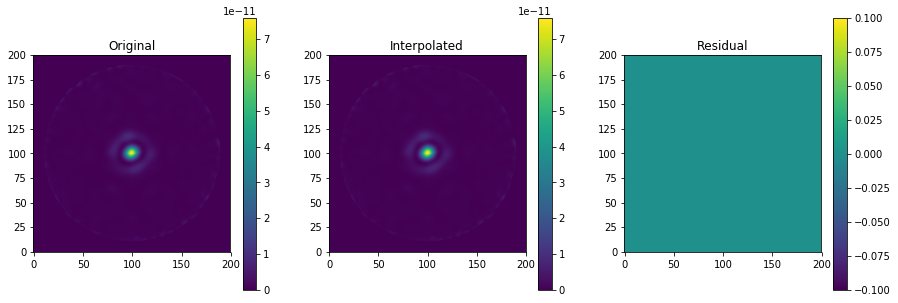

In [10]:
# Now do the interpolation
n = 200 # the x,y grid can be interpolated interpolated over a 200x200 grid

x = range(n)
y = range(n)
z = xmas

my_interpolating_function = RegularGridInterpolator((x, y, z), 
                                                    hlcpsfs,
                                                    bounds_error = False,
                                                    method = "linear", #~2x faster than linear
                                                    fill_value = 0)

grid = np.meshgrid(x,y)
pts = np.vstack([np.vstack([grid[0].flatten(),grid[1].flatten()]),0*np.ones(len(grid[0].flatten()))]).T
interpped = my_interpolating_function(pts).reshape(n,n).T

# Now display everything
plt.figure(figsize=[15,5])

# Plot the original PSF
plt.subplot(131)
plt.title("Original")
plt.imshow(hlcpsfs[:,:,0])
plt.colorbar()
# Plot the interpolated PSF
plt.subplot(132)
plt.title("Interpolated")
plt.imshow(interpped)
plt.colorbar()
# Plot the inerpolated - original PSF
plt.subplot(133)
plt.title("Residual")
plt.imshow(interpped-hlcpsfs[:,:,0])
plt.colorbar()

plt.show()

In [11]:
hlc_processing.USE_OPENCV
# if true, then cv2 was imported successfully
# if false, cv2 cannot be imported and instead scipy.ndimage is imported

False

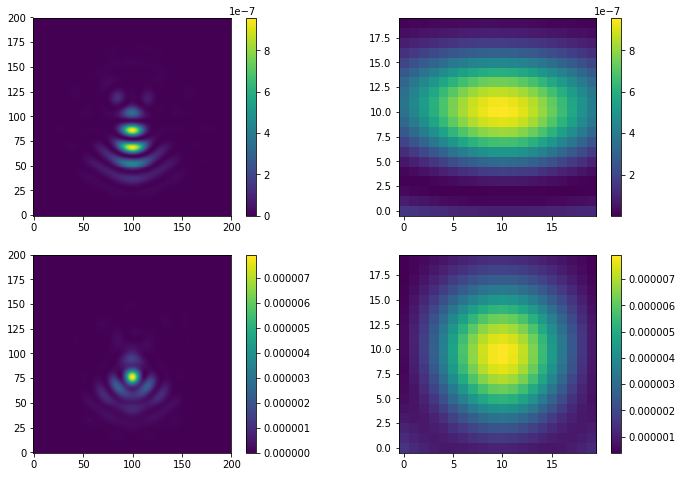

In [12]:
reload(hlc_processing)

HLC_plate_scale = fits_header["PIX_AS"]*u.arcsec # arcsec/pixel of HLC PSFs
mask_radius = 0.7/fits_header["PIX_AS"]

plt.figure(figsize=[12,8])

planet1 = hlc_processing.closest_monochrome_PSF(30*u.milliarcsecond,0*u.milliarcsecond,
                                              my_interpolating_function,
                                              xmas,
                                              HLC_plate_scale,
                                              mask_radius = mask_radius)

plt.subplot(221)
plt.imshow(planet1[:,:])
plt.colorbar()

i,j = np.unravel_index(np.argmax(planet1), np.shape(planet1))
plt.subplot(222)
plt.imshow(planet1[i-10:i+10,j-10:j+10])
plt.colorbar()

planet2 = hlc_processing.closest_monochrome_PSF(60*u.milliarcsecond,0*u.milliarcsecond,
                                              my_interpolating_function,
                                              xmas,
                                              HLC_plate_scale,
                                              mask_radius = mask_radius)

plt.subplot(223)
plt.imshow(planet2[:,:])
plt.colorbar()

i,j = np.unravel_index(np.argmax(planet2), np.shape(planet2))
plt.subplot(224)
plt.imshow(planet2[i-10:i+10,j-10:j+10])
plt.colorbar()

plt.show()

# The prun command is for benchmarking so uncomment it to understand what is going on
# %prun hlc_processing.closest_monochrome_PSF(-300*u.milliarcsecond,200*u.milliarcsecond,my_interpolating_function,xmas,HLC_plate_scale,mask_radius=mask_radius)


## zodipic_10pc03mas01alpha.fits

### Output files:
zodipic_10pc03mas01alpha_HLC.fits

zodipic_10pc03mas01alpha_1e+32_input.fits

zodipic_10pc03mas01alpha_coremasked_HLC.fits

zodipic_10pc03mas01alpha_1e+32_coremasked_input.fits

1562527162.910244
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics\zodipic_10pc03mas01alpha.fits
<class 'float'>


KeyboardInterrupt: 

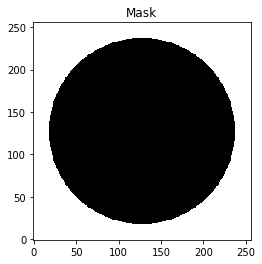

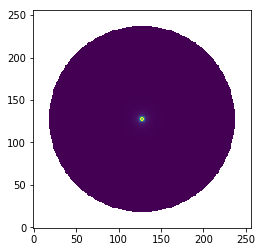

In [12]:
reload(hlc_processing)
start_time = time.time() # for timing purposes
print(start_time)

zodi_fname = "zodipic_10pc03mas01alpha.fits"
zodi_path = my_home_dir + "\zodipics\\" + zodi_fname
print(zodi_path)
print(type(thresh))
core_mask_radius = .15*u.arcsec
im,zodi = hlc_processing.fit_to_hlc(zodi_path,
                                    my_interpolating_function,
                                    xmas,
                                    HLC_plate_scale,
                                    display=True,
                                    thresh=thresh)

im_name = zodi_path[:-5] + "_HLC.fits"
zodi_header = fits.getheader(zodi_path)
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value
fits.writeto(im_name, im, overwrite=True, header=zodi_header) 

zodi_name = zodi_path[:-5] + str(thresh) + "_input.fits"
fits.writeto(zodi_name, zodi.filled(fill_value = 0), overwrite = True)

print(time.time()-start_time)


1562107708.8379657
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics\zodipic_10pc03mas01alpha.fits
433.3138008117676


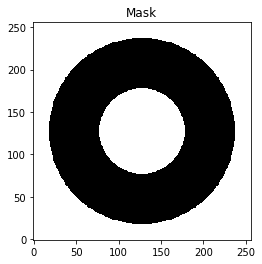

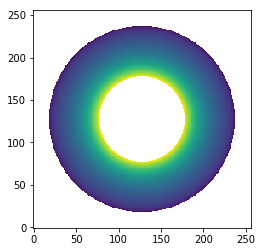

In [50]:
start_time = time.time() # for timing purposes
print(start_time)

zodi_fname = "zodipic_10pc03mas01alpha.fits"
zodi_path = my_home_dir + "\zodipics\\" + zodi_fname
print(zodi_path)

# Now do it with the core_mask_radius
core_mask_radius = .15*u.arcsec
im,zodi = hlc_processing.fit_to_hlc(zodi_path,
                                    my_interpolating_function,
                                    xmas,
                                    HLC_plate_scale,
                                    display=True,
                                    core_mask_radius=core_mask_radius,
                                    thresh=thresh)

im_name = zodi_path[:-5] + "_coremasked_HLC.fits"
zodi_header = fits.getheader(zodi_path)
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value
fits.writeto(im_name, im, overwrite = True, header = zodi_header)

zodi_name = zodi_path[:-5] + "_" + str(thresh) + "_coremasked_input.fits"
fits.writeto(zodi_name, zodi.filled(fill_value = 0), overwrite=True)

print(time.time()-start_time)

## zodipic_03pc03mas.fits

### Output files:

zodipic_03pc03mas_HLC.fits

zodipic_03pc03mas_1e+32.fits

1562110834.194209
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics\zodipic_03pc03mas.fits
1212.2195250988007


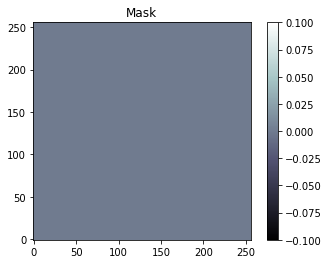

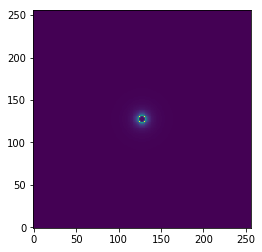

In [57]:
start_time = time.time() # for timing purposes
print(start_time)

zodi_fname = "zodipic_03pc03mas.fits"
zodi_path = my_home_dir + "\zodipics\\" + zodi_fname
print(zodi_path)

im,zodi = hlc_processing.fit_to_hlc(zodi_path,
                                    my_interpolating_function,
                                    xmas,
                                    HLC_plate_scale,
                                    display=True,
                                    thresh = thresh)

im_name = zodi_path[:-5]+"_HLC.fits"
zodi_header = fits_header.copy()
zodi_header["thresh"] = thresh
fits.writeto(im_name, im, overwrite=True, header=zodi_header)

zodi_name = zodi_path[:-5] + "_" + str(thresh) + ".fits"
fits.writeto(zodi_name, zodi.filled(fill_value=0), overwrite=True)

print(time.time()-start_time)

## zodipics_10pc03mas.fits

### Output files:
zodipic_10pc03mas_HLC.fits

zodipic_10pc03mas_coremasked_HLC.fits

1562109478.5954795
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics\zodipic_10pc03mas.fits
1133.1120450496674


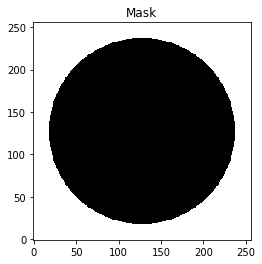

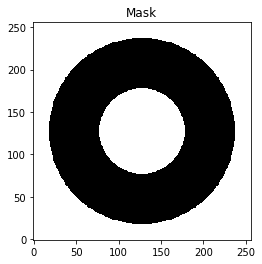

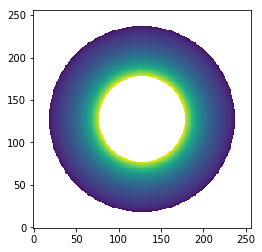

In [53]:
start_time = time.time() # for timing purposes
print(start_time)

zodi_fname = "zodipic_10pc03mas.fits"
zodi_file = my_home_dir + "\zodipics\\" + zodi_fname
print(zodi_file)

im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                    my_interpolating_function,
                                    xmas,
                                    HLC_plate_scale,
                                    display=True,
                                    thresh=1e32)

im_name = zodi_file[:-5] + "_HLC.fits"
fits.writeto(im_name,im,overwrite=True,header=fits.getheader(zodi_file))

im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                    my_interpolating_function,
                                    xmas,
                                    HLC_plate_scale,
                                    display=True,
                                    core_mask_radius=core_mask_radius,
                                    thresh=1e32)

im_name = zodi_file[:-5] + "_coremasked_HLC.fits"
fits.writeto(im_name, im, overwrite = True, header = fits.getheader(zodi_file)) # fits.writeto(outfits,im,overwrite=True)

print(time.time()-start_time)

## zodipic_10pc03mas01alpha.fits again

### Output files:

zodipic_10pc03mas01alpha_HLC_1e+32.fits

zodipic_10pc03mas01alpha_HLC_1e+32_input.fits

zodipic_10pc03mas01alpha_HLC_1e+32_masked_146.85458459033865.fits

1562276394.555138
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics\zodipic_10pc03mas01alpha.fits


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\zodipics\\zodipic_10pc03mas01alpha_HLC_1e+32_input.fits'

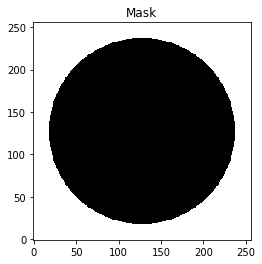

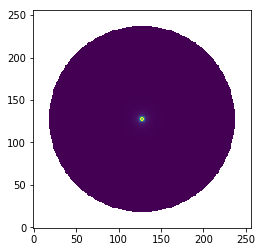

In [25]:
reload(hlc_processing)

start_time = time.time() # for timing purposes
print(start_time)

zodi_file = my_home_dir + "\zodipics\\" + "zodipic_10pc03mas01alpha.fits"
print(zodi_file)

im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                    my_interpolating_function,
                                    xmas,
                                    HLC_plate_scale,
                                    display=True,
                                    thresh=1e32)

im_name = zodi_file[:-5] + "_HLC_" + str(thresh) + ".fits"
fits.writeto(im_name, im, overwrite = True, header = fits.getheader(zodi_file))

zodi_name = zodi_file[:-5] + "_HLC_" + str(thresh) + "_input.fits"
fits.writeto(zodi_name,zodi.filled(fill_value = 0), overwrite = True)

im_m,zodi_m = hlc_processing.fit_to_hlc(zodi_file,
                                        my_interpolating_function,
                                        xmas,
                                        HLC_plate_scale,
                                        display=True,
                                        thresh=1e32,
                                        mask_radius=mask_radius)

im_m_name = zodi_file[:-5] +"_HLC_" + str(thresh) + "_masked_" + str(mask_radius) + ".fits"
fits.writeto(im_m_name, im_m, overwrite = True, header = fits.getheader(zodi_file))

print(time.time()-start_time)

In [13]:
zodi_file = my_home_dir + "\zodipics\\" + "zodipic_10pc03mas01alpha.fits"

im_name = zodi_file[:-5] + "_HLC_" + str(thresh) + ".fits"
im_m_name = zodi_file[:-5] +"_HLC_" + str(thresh) + "_masked_" + str(mask_radius) + ".fits"
zodi_name = zodi_file[:-5] + "_HLC_" + str(thresh) + "_input.fits"

im = fits.getdata(im_name)
im_m = fits.getdata(im_m_name)
zodi_m = fits.getdata(zodi_name)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics\zodipic_10pc03mas01alpha.fits


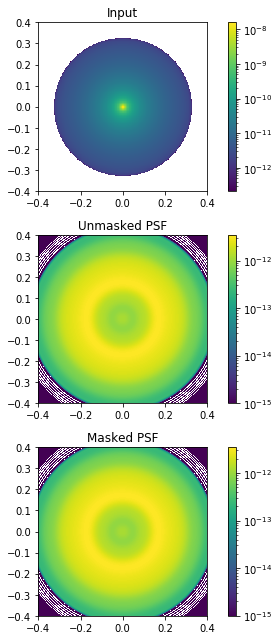

In [14]:
zodi_file = my_home_dir + "\zodipics\\" + "zodipic_10pc03mas01alpha.fits"
print(zodi_file)

zodi_fits = fits.open(zodi_file)
zodi_pixscale = zodi_fits[0].header["PIXELSCL"]*u.arcsecond

plt.figure(figsize=[6,9])

x_hlc,y_hlc = np.meshgrid(np.arange(-n/2,n/2),np.arange(-n/2,n/2))
x_hlc = (x_hlc+.5).flatten()*HLC_plate_scale
y_hlc = (y_hlc+.5).flatten()*HLC_plate_scale
halfpix_hlc = HLC_plate_scale.to(u.arcsec).value*0.5
halfpix = zodi_pixscale.to(u.arcsec).value*0.5

HLC_extent = ([x_hlc.min().to(u.arcsec).value-halfpix,
               x_hlc.max().to(u.arcsec).value+halfpix, 
               y_hlc.min().to(u.arcsec).value-halfpix,
               y_hlc.max().to(u.arcsec).value+halfpix])

fov = .4

pixnum = np.int(zodi_m.shape[0])

x,y = np.meshgrid(np.arange(-pixnum/2,pixnum/2),np.arange(-pixnum/2,pixnum/2))
x = (x+.5).flatten()*zodi_pixscale
y = (y+.5).flatten()*zodi_pixscale

zodi_extent = ([x.min().to(u.arcsec).value-halfpix,
                x.max().to(u.arcsec).value+halfpix, 
                y.min().to(u.arcsec).value-halfpix,
                y.max().to(u.arcsec).value+halfpix])

plt.subplot(311)
plt.title("Input")
plt.imshow(zodi_m,norm=LogNorm(),extent=zodi_extent)
plt.xlim([-fov,fov])
plt.ylim([-fov,fov])
plt.colorbar()

plt.subplot(312)
plt.xlim([-fov,fov])
plt.ylim([-fov,fov])
plt.title("Unmasked PSF")
plt.imshow(im,interpolation="nearest",norm=LogNorm(),extent=HLC_extent,vmin=1e-15)
plt.colorbar()

plt.subplot(313)
plt.title("Masked PSF")
plt.xlim([-fov,fov])
plt.ylim([-fov,fov])
plt.imshow(im_m,interpolation="nearest",norm=LogNorm(),extent=HLC_extent,vmin=1e-15)
plt.colorbar()

plt.tight_layout()
plt.savefig(zodi_file[:-5]+"_input_outputs"+str(mask_radius)+"_mask.pdf",bbox_inches="tight")

plt.show()


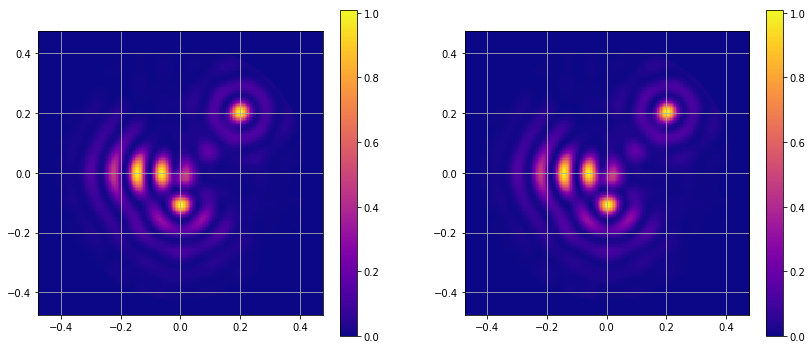

In [15]:
#check that coordinates match expectation.
plt.figure(figsize=[7*2,3*2])

plt.subplot(121)
planet1 = hlc_processing.closest_monochrome_PSF(100*u.milliarcsecond,0*u.milliarcsecond,
                                                my_interpolating_function,
                                                xmas,
                                                HLC_plate_scale,
                                                mask_radius=mask_radius) 

planet2 = hlc_processing.closest_monochrome_PSF(0*u.milliarcsecond,-40*u.milliarcsecond,
                                                my_interpolating_function,
                                                xmas,
                                                HLC_plate_scale,
                                                mask_radius=mask_radius)

planet3 = hlc_processing.closest_monochrome_PSF(-200*u.milliarcsecond,200*u.milliarcsecond,
                                                my_interpolating_function,
                                                xmas,
                                                HLC_plate_scale,
                                                mask_radius=mask_radius)

plt.imshow(np.array(planet1/planet1.max()+planet2/planet2.max()+planet3/planet3.max()),
           cmap = plt.cm.plasma,
           interpolation="nearest",
           extent=HLC_extent)
plt.grid()
plt.colorbar()

plt.subplot(122)
planet1=hlc_processing.closest_monochrome_PSF(100*u.milliarcsecond,0*u.milliarcsecond,
                                              my_interpolating_function,
                                              xmas,
                                              HLC_plate_scale)

planet2=hlc_processing.closest_monochrome_PSF(0*u.milliarcsecond,-40*u.milliarcsecond,
                                              my_interpolating_function,
                                              xmas,
                                              HLC_plate_scale)

planet3=hlc_processing.closest_monochrome_PSF(-200*u.milliarcsecond,200*u.milliarcsecond,
                                              my_interpolating_function,
                                              xmas,
                                              HLC_plate_scale)

plt.imshow(np.array(planet1/planet1.max()+planet2/planet2.max()+planet3/planet3.max()),
           cmap=plt.cm.plasma, 
           interpolation="nearest",
           extent=HLC_extent)
plt.grid()
plt.colorbar()

plt.savefig("normalized_psfs"+str(mask_radius)+"_mask.pdf",bbox_inches="tight")
plt.show()

C:\Users\Kian\Anaconda3\envs\webbpsf-env\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


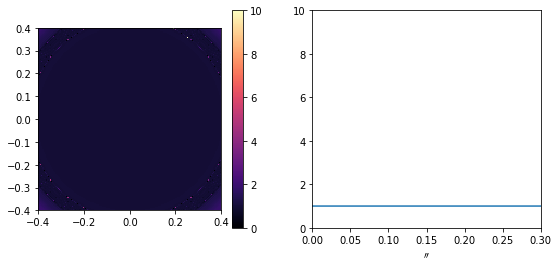

In [18]:
#plot ratio map and radial curve
plt.figure(figsize=[9,4])

plt.subplot(121)
ratio = im/im_m
plt.imshow(ratio, 
           extent=HLC_extent, 
           interpolation="nearest",
           vmin=0, vmax=10, #norm=LogNorm(),
           cmap=plt.cm.magma)

plt.colorbar()#orientation="horizontal")
plt.xlim([-fov,fov])
plt.ylim([-fov,fov])

plt.subplot(122)
plt.plot(x_hlc[0:200],ratio[:,100])
plt.xlim([0,.3])
plt.ylim([0,10])
plt.xlabel("$\prime\prime$")

fits.writeto(im_m_name+"ratio.fits",ratio,zodi_fits[0].header,overwrite=True)
plt.savefig(im_m_name+"ratio.pdf",bbox_inches="tight")
plt.show()


C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\zodipics\zodipic_10pc03mas01alpha.fits


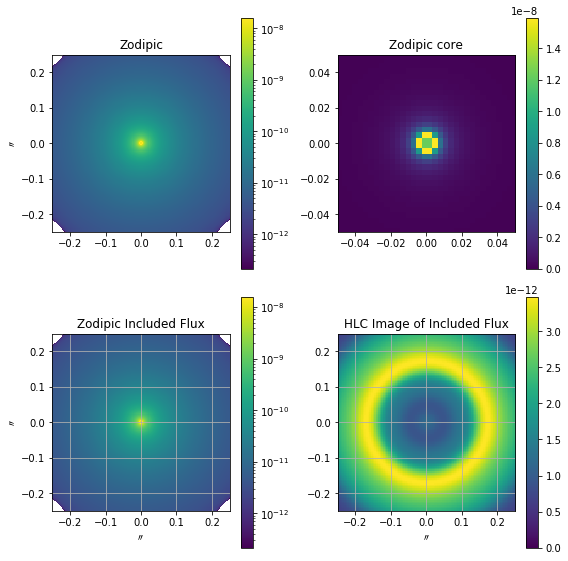

<Figure size 432x288 with 0 Axes>

In [16]:
zodi_file = my_home_dir + "\zodipics\\" + "zodipic_10pc03mas01alpha.fits"
print(zodi_file)

zodi = fits.open(zodi_file)[0]

plt.figure(figsize=[8,8])

plt.subplot(221)
plt.imshow(zodi.data,norm=LogNorm(),extent=zodi_extent,)
plt.colorbar()
plt.ylabel("$\prime\prime$")
plt.xlim([-.25,.25])
plt.ylim([-.25,.25])
plt.title("Zodipic")

plt.subplot(222)
plt.imshow(zodi.data,extent=zodi_extent)
plt.colorbar()
plt.title("Zodipic core")
plt.xlim([-.05,.05])
plt.ylim([-.05,.05])

plt.subplot(223)
plt.title("Zodipic Included Flux")
plt.xlim([-.25,.25])
plt.ylim([-.25,.25])
plt.ylabel("$\prime\prime$")
plt.xlabel("$\prime\prime$")
plt.grid()
plt.imshow(zodi.data,extent=zodi_extent,norm=LogNorm(zodi.data[zodi.data>0].min(),zodi.data.max()))#zodi.data.min(),zodi.data.max))
plt.colorbar()

plt.subplot(224)
plt.imshow(im,extent=HLC_extent)
plt.colorbar()
plt.title("HLC Image of Included Flux")
plt.xlim([-.25,.25])
plt.ylim([-.25,.25])
plt.grid()
plt.xlabel("$\prime\prime$")

plt.tight_layout()
plt.show()

plt.savefig("Zodipic_HLC_1_5mas.png")

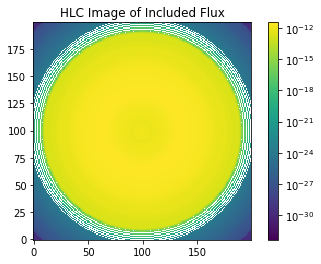

In [17]:
plt.imshow(im,norm=LogNorm())#1e-20,1e-15))
plt.colorbar()
plt.title("HLC Image of Included Flux")
plt.show()

In [18]:
from webbpsf import wfirst
import importlib
importlib.reload(wfirst)

ifs_spc = wfirst.CGI(pixelscale=out_pixscale)
ifs_spc.mode = 'DISKSPC_F721'#CHARSPC_F770' #
#ifs_spc.cgi_family = "DISKSPC"

ifs_spc.cgi_family = "CHARSPC"

FOV=2*1.64

#example cube 
input_fname = my_home_dir + "\zodipics\\" + "zodipic_10pc03mas01alpha.fits"
dust = fits.open(input_fname)

#define adjustable cropping factor
border = 1
input_cube = dust[0].data

dust[0].header["INPUT_FITS"] = input_fname
dust[0].header["PIXELSCL"] = 0.01425
dust[0].header["INPUT_flux"] = "Jy"

#location of center from Ds9 inspection
'''
DS9 coordinate notes, corners are from 0.5-213.5 and center is at 108.
In numpy coordinates the center is at 107,107
'''
center = (107-border)

# find parameters:
dim = input_cube.shape
if len(dim)>2:
    ny = dim[1]
    nx = dim[2]
else:
    ny = dim[0]
    nx = dim[1] 
#test that center is center by removing the flux
#input_cube [0,center,center] =1e-11

## Make video of PSFs

200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025
200 200 5.0 marcsec 0.0025


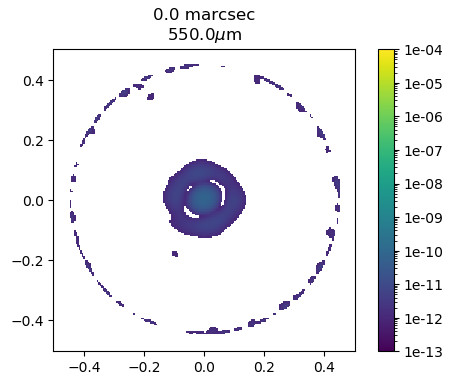

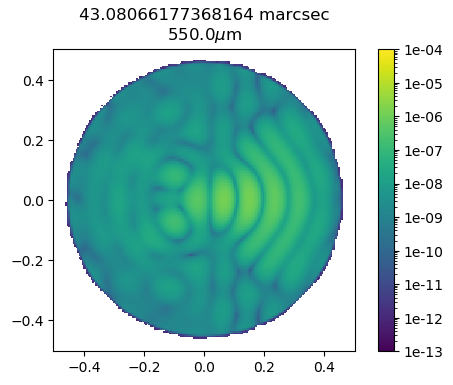

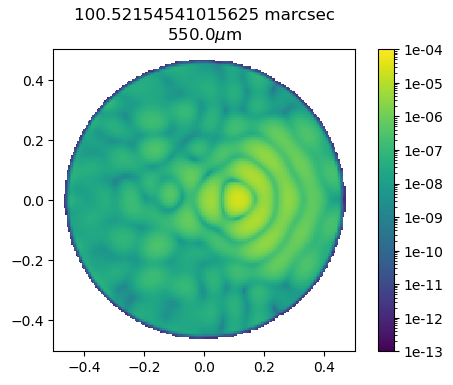

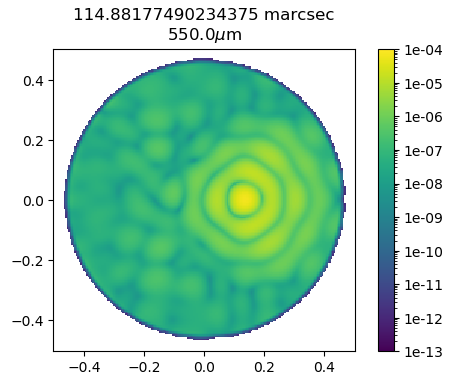

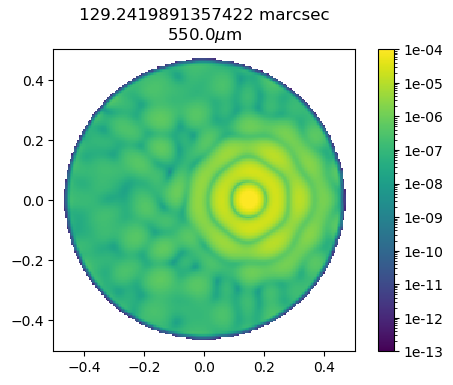

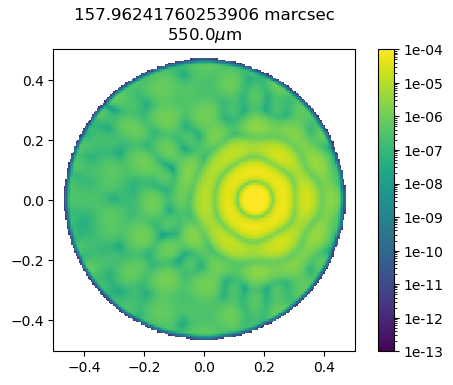

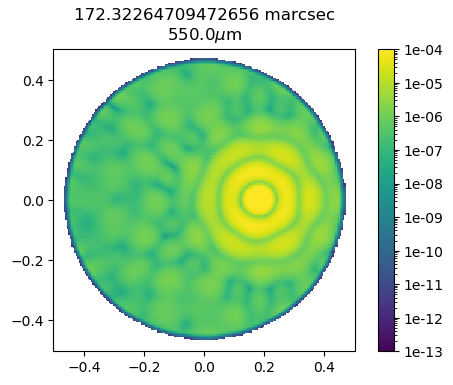

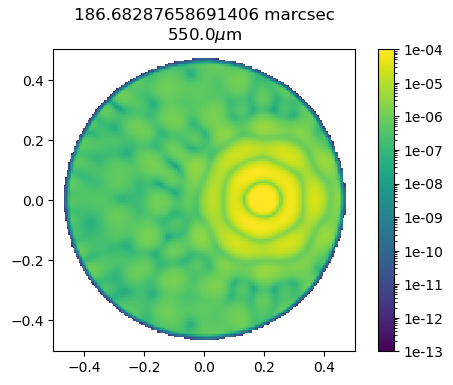

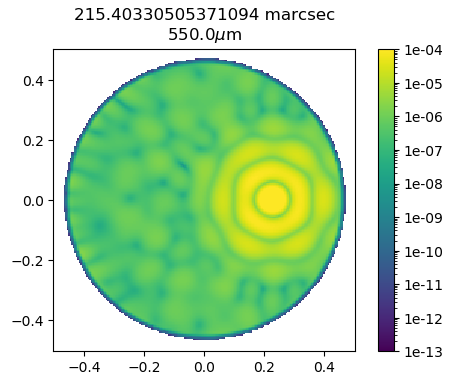

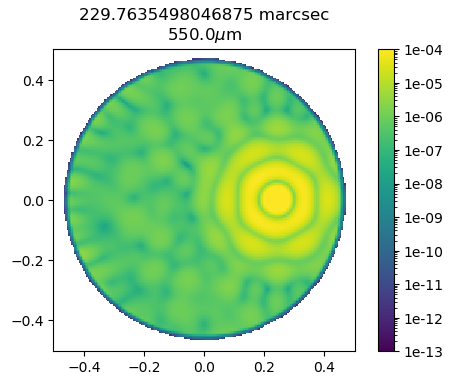

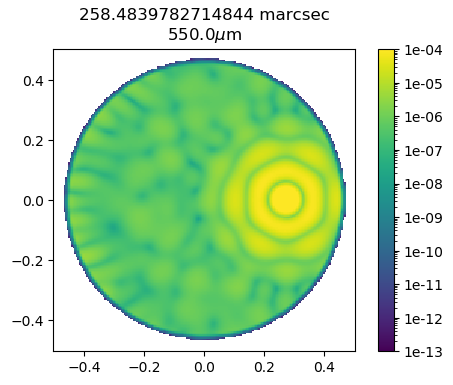

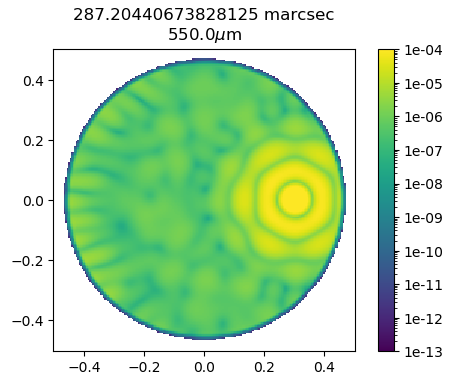

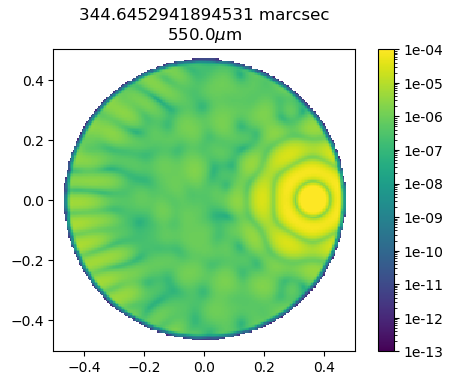

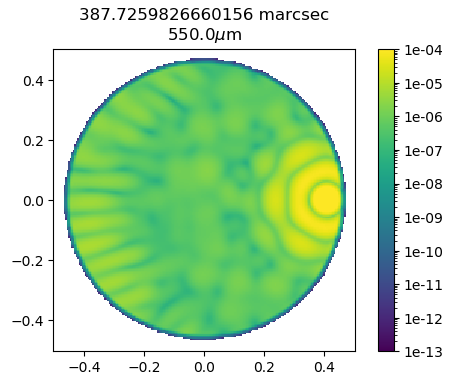

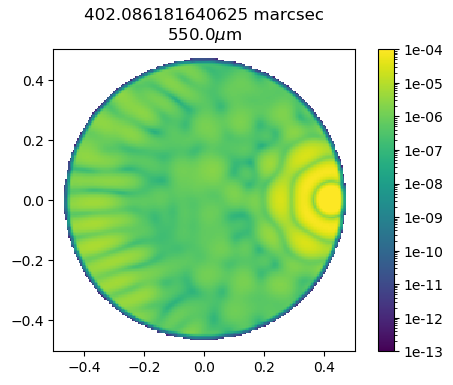

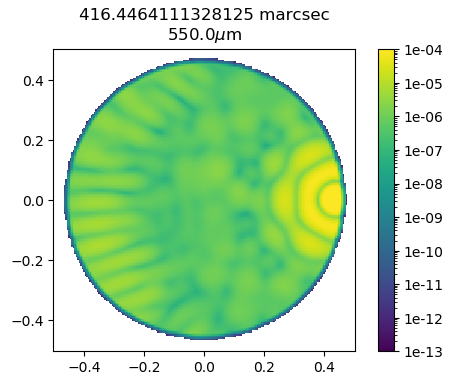

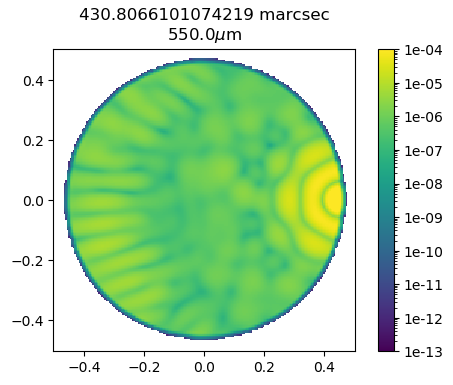

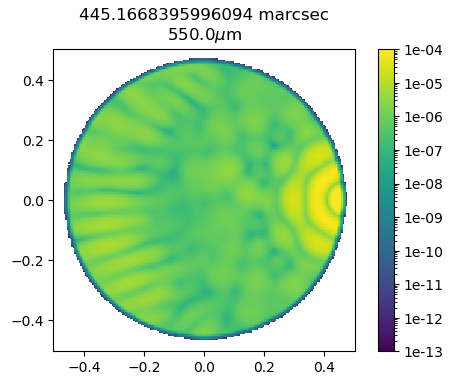

In [19]:
hlcpsfs[hlcpsfs[:,:,:]<1e-12] = 0

for i,angle in enumerate(xmas):
    plt.figure(dpi=100)
    
    displ_scale(hlcpsfs[:,:,i],ps=5*u.milliarcsecond,norm=LogNorm(vmax=1e-4,vmin=1e-13))
    
    plt.title(str(angle)+"\n"+str(fits_header["LAM_C"])+"$\mu$m")
    plt.savefig("PSFanimation\\" + str(angle)[:3] + "mas_PSF.png")


In [33]:
%%cmd
convert -quality 100% -delay 10 -loop 0 $(ls \PSFanimation\*mas_PSF.png | sort -n)  HLC_animation.mpg

Microsoft Windows [Version 10.0.17134.829]
(c) 2018 Microsoft Corporation. All rights reserved.

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection>convert -quality 100% -delay 10 -loop 0 $(ls *mas_PSF.png | sort -n)  HLC_animation.mpg

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection>

Invalid Parameter - 100%




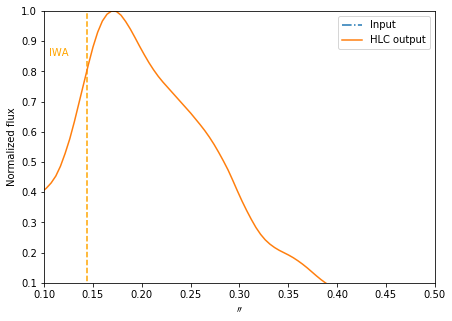

In [20]:
import poppy

plt.figure(figsize=[7,5])

ax = plt.subplot(111)
zodi_r_axis,zodi_ravg = poppy.utils.radial_profile(zodi_fits)
header=fits_header
header['PIXELSCL'] = header['PIX_AS']
r_axis,ravg = poppy.utils.radial_profile(fits.HDUList([fits.ImageHDU(im,header)]))

ax.plot(zodi_r_axis/1000,zodi_ravg/zodi_ravg.max(),'-.',label="Input")

ax.plot([lambda_D.decompose()*206265*3,lambda_D.decompose()*206265*3],[1e-12, 1],'--',color="orange")
ax.text(lambda_D.decompose()*206265*2.2,.85,"IWA",color="orange")

ax.plot(r_axis,ravg/ravg.max(),label="HLC output")
ax.set_ylim([.1,1])
ax.set_xlim([.1,.5])

plt.xlabel("$\prime\prime$")
plt.ylabel("Normalized flux")
plt.legend()
plt.show()

In [35]:
def disk_through_hlc(fitsfile,
                     thresh=1000,
                     display=False,
                     x_extent=.25,y_extent=0.25,
                     load_existing=True,
                     localzodi=0):
    
    print("Running disk through HLC ...")
    zodi_fits = fits.open(fitsfile)
    fitsfile_parts = fitsfile.split("\\")
    outfits = my_home_dir + "\KianDebesModels\\" + fitsfile_parts[7] + "\\" + fitsfile_parts[8][:-5] + '_HLC.fits'
    print("Input file: ")
    print(fitsfile)
    print("Output file: ")
    print(outfits)

    if fitsfile.find("89") !=-1:
        thresh=50000

    print(thresh)
    print("local zodi: {}".format(localzodi))

    zodi = np.ma.masked_array(zodi_fits[0].data,zodi_fits[0].data<zodi_fits[0].data.max()/thresh)
    zodi_fits[0].data=zodi
    n = 200
    zodi_pixscale = zodi_fits[0].header["PIXELSCL"]*u.arcsecond

    pixnum = np.int(zodi_fits[0].data.shape[0])
    x,y = np.meshgrid(np.arange(-pixnum/2,pixnum/2),np.arange(-pixnum/2,pixnum/2))
    x = (x+.5).flatten()*zodi_pixscale

    y = (y+.5).flatten()*zodi_pixscale
    im = np.zeros([n,n])

    zodi.mask#[zodi<zodi.max()/100] = True
    if display:
        plt.imshow(zodi)
    try:
        if load_existing:
            im=fits.getdata(outfits)
        else:
            print("load_existing keyword False, throwing error to regenerate file ")
            raise ValueError("")

    except:
        for i,zodi_val in enumerate(zodi.flatten()):
            if np.ma.is_masked(zodi_val):
                continue
            im += (localzodi+zodi_val)*hlc_processing.closest_monochrome_PSF(x[i],y[i],
                                                                             my_interpolating_function,
                                                                             xmas,
                                                                             HLC_plate_scale)
    if display:
        halfpix = zodi_pixscale.to(u.arcsec).value*0.5
        extent = ([x.min().to(u.arcsec).value-halfpix,
                   x.max().to(u.arcsec).value+halfpix, 
                   y.min().to(u.arcsec).value-halfpix,
                   y.max().to(u.arcsec).value+halfpix])
        
        plt.figure(figsize=[9,4])
        
        plt.subplot(121)
        plt.title("Input Flux")
        plt.xlim([-x_extent,x_extent])
        plt.ylim([-y_extent,y_extent])
        plt.ylabel("$\prime\prime$")
        plt.xlabel("$\prime\prime$")
        plt.grid()
        plt.imshow(zodi,extent=extent,norm=LogNorm(zodi.data[zodi>0].min(),zodi.data.max()))#zodi.data.min(),zodi.data.max))
        axc = plt.colorbar()
        axc.set_label("Jy")
        
        plt.subplot(122)
        pixnum = np.int(im.shape[0])
        x,y = np.meshgrid(np.arange(-pixnum/2,pixnum/2),np.arange(-pixnum/2,pixnum/2))
        x = (x+.5).flatten()*fits_header["PIX_AS"]*u.arcsec
        y = (y+.5).flatten()*fits_header["PIX_AS"]*u.arcsec
        halfpix = fits_header["PIX_AS"]*.05
        extent = ([x.min().to(u.arcsec).value-halfpix,
        x.max().to(u.arcsec).value+halfpix, 
        y.min().to(u.arcsec).value-halfpix,
        y.max().to(u.arcsec).value+halfpix])
        plt.imshow(im.T,extent=extent)
        plt.colorbar()
        plt.title("HLC Image of Included Flux")
        plt.xlim([-x_extent,x_extent])
        plt.ylim([-y_extent,y_extent])
        plt.grid()
        plt.xlabel("$\prime\prime$")
        plt.tight_layout()
        
        plt.show()
        
    return im,zodi_fits,outfits


# Model_Annulus\annulus_inc60_r0.4.fits

Running disk through HLC ...
Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc60_r0.4.fits
Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels\Model_Annulus\annulus_inc60_r0.4_HLC.fits
5
local zodi: 0
load_existing keyword False, throwing error to regenerate file 


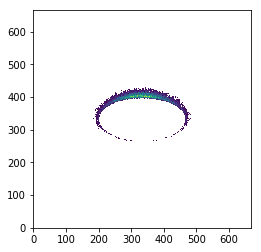

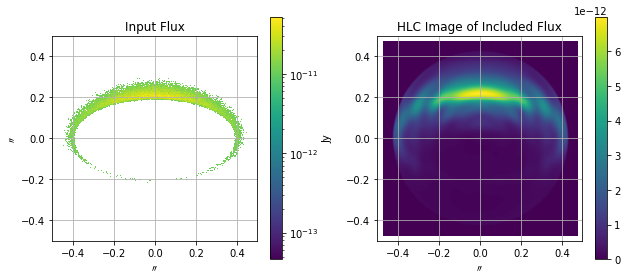

258.34239196777344


In [36]:
fitsfile = my_home_dir + "\DebesModels\\" + "Model_Annulus\\" + "annulus_inc60_r0.4.fits"

start_time = time.time()

im,zodi,outfits = disk_through_hlc(fitsfile,
                                   thresh=5,
                                   display=True,
                                   x_extent = 0.5,y_extent = 0.5,
                                   load_existing=False)

end_time = time.time()
print(end_time-start_time)

fits.writeto(outfits, im, overwrite = True)


# Model_Annulus\annulus_inc89_r0.1.fits

Running disk through HLC ...
Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc89_r0.1.fits
Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels\Model_Annulus\annulus_inc89_r0.1_HLC.fits
50000
local zodi: 0
load_existing keyword False, throwing error to regenerate file 


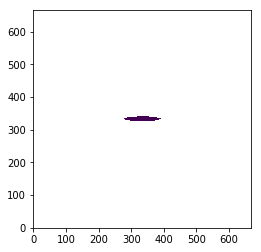

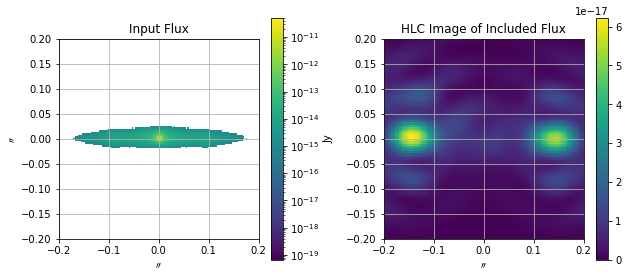

44.074108362197876


In [37]:
fitsfile = my_home_dir + "\DebesModels\\" + "Model_Annulus\\" + "annulus_inc89_r0.1.fits"

start_time = time.time()

im,zodi,outfits = disk_through_hlc(fitsfile,
                                   thresh=5,
                                   display=True,
                                   x_extent = 0.2,y_extent = 0.2,
                                   load_existing=False)

end_time = time.time()
print(end_time-start_time)

fits.writeto(outfits, im, overwrite = True)


# Model_ConstantTau\constanttau_inc0_r0.2.fits

Running disk through HLC ...
Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_ConstantTau\constanttau_inc0_r0.2.fits
Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels\Model_ConstantTau\constanttau_inc0_r0.2_HLC.fits
5
local zodi: 0
load_existing keyword False, throwing error to regenerate file 


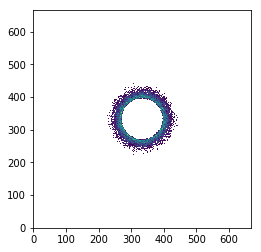

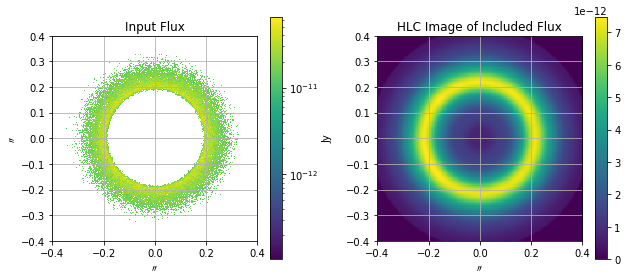

551.1945097446442


In [38]:
fitsfile = my_home_dir + "\DebesModels\\" + "Model_ConstantTau\\" + "constanttau_inc0_r0.2.fits"

start_time = time.time()

im,zodi,outfits = disk_through_hlc(fitsfile,
                                   thresh=5,
                                   display=True,
                                   x_extent = 0.4,y_extent = 0.4,
                                   load_existing=False)

end_time = time.time()
print(end_time-start_time)

fits.writeto(outfits, im, overwrite = True)


# Model_Ring\ring_inc0_r0.5.fits

In [ ]:
fitsfile = my_home_dir + "\DebesModels\\" + "Model_Ring\\" + "ring_inc0_r0.5.fits"

start_time = time.time()

im,zodi,outfits = disk_through_hlc(fitsfile,
                                   thresh=5,
                                   display=True,
                                   x_extent = 0.5,y_extent = 0.5,
                                   load_existing=False)

plt.show()

end_time = time.time()
print(end_time-start_time)

fits.writeto(outfits, im, overwrite = True)


Running disk through HLC ...
Input file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Ring\ring_inc0_r0.5.fits
Output file: 
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\KianDebesModels\Model_Ring\ring_inc0_r0.5_HLC.fits
5
local zodi: 0
load_existing keyword False, throwing error to regenerate file 


# Model_GAP\gap_inc45_r0.2.fits

In [ ]:
fitsfile = my_home_dir + "\DebesModels\\" + "Model_GAP\\" + "gap_inc45_r0.2.fits"

start_time = time.time()

im,zodi,outfits = disk_through_hlc(fitsfile,
                                   thresh=5,
                                   display=True,
                                   x_extent = 0.4,y_extent = 0.4,
                                   load_existing=False)

plt.show()

end_time = time.time()
print(end_time-start_time)

fits.writeto(outfits, im, overwrite = True)


In [21]:
inner=[s for s in debes_models if "0.4" in s]
#on_axis.sort()
debes_models.sort()#reverse=True)
#gap.sort()
subset=['\DebesModels\Model_Annulus\annulus_inc45_r0.2.fits',
        #'/Users/edouglas/Box Sync/WFIRST_SIT_FILES/DebesModels/Model_Annulus/annulus_inc45_r0.1.fits',
        #'/Users/edouglas//Box Sync/WFIRST_SIT_FILES/annulus_inc45_r0.4.fits',
       ]

In [22]:
import traceback
    
def process_file(model):
    print(model)
    zodi_r_axis,zodi_ravg=poppy.utils.radial_profile(model)
    
    try:    
        if model.find("zodipic") == 0:
            thresh=2500
            zoomf=1
            zodi_r_axis=zodi_r_axis/1000
        else:
            thresh=1/im.min()
            zoomf=2
        plt.figure(figsize=[9,4])

        im,zodi_fits,outfile=disk_through_hlc(model,thresh=thresh,
                                              display=True,
                                              load_existing=False,
                                              #y_extent=float(model[-8:-5])*zoomf,
                                              #x_extent=float(model[-8:-5])*zoomf,
                                              localzodi=localzodi)
        out_HDU = fits.HDUList([fits.PrimaryHDU([im])])
        out_HDU[0].header = zodifits.header
        out_HDU[0].header["LOCALZODI"]=localzodi
        out_HDU[0].header["PIXELSCL"]=HLC_plate_scale.value
        if localzodi ==0:
            file = model.split("/")[-1][:-4]+'_HLC.fits'
            path = model.split("/")[-1][:-4]+'_HLC.fits'
        else:
            file = model.split("/")[-1][:-4]+'_localHLC.fits'
            path = model.split("/")[-1][:-4]+'_localHLC.fits'
        out_HDU.write(outfits,overwrite=True)
        plt.savefig(model[:-4]+'_HLC.png')
        plt.figure(figsize=[4,3])
        ax=plt.subplot(111)#,aspect='equal')
        #ax.set_aspect(1)

        r_axis,ravg=poppy.utils.radial_profile(fits.HDUList([fits.ImageHDU(im,header=HLC_header)]))

        ax.plot(zodi_r_axis,zodi_ravg/np.nanmax(zodi_ravg),'-.',label="Input")

        ax.plot([lambda_D.decompose()*206265*3,lambda_D.decompose()*206265*3],[1e-12, 1],'--',color="orange")
        ax.text(lambda_D.decompose()*206265*2.2,.85,"IWA",color="orange")

        ax.plot(r_axis,ravg/ravg.max(),label="HLC output")
        ax.set_ylim([.1,1])
        ax.set_xlim([-.05,.5])

        #plt.yscale("log")
        plt.xlabel("$\prime\prime$")
        plt.ylabel("Normalized flux")
        plt.legend()
        plt.savefig(model[:-4]+'_HLC_curve.png',bbox_inches="tight")
        plt.close()

    except Exception as err:
        traceback.print_last()
        #traceback.print_tb(err.__traceback__)

for model in ["localzodi.fits"]:
    process_file(model)

localzodi.fits


Traceback (most recent call last):
  File "C:\Users\Kian\Anaconda3\envs\webbpsf-env\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-95492b45ade3>", line 15, in <module>
    thresh=thresh)
  File "C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\hlc_processing.py", line 69, in fit_to_hlc
    mask_radius=mask_radius)
  File "C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\hlc_processing.py", line 106, in closest_monochrome_PSF
    interpped = rotate(HLCinterpfun(pts).reshape(n,n).T,
  File "C:\Users\Kian\Anaconda3\envs\webbpsf-env\lib\site-packages\scipy\interpolate\interpolate.py", line 2484, in __call__
    out_of_bounds)
  File "C:\Users\Kian\Anaconda3\envs\webbpsf-env\lib\site-packages\scipy\interpolate\interpolate.py", line 2506, in _evaluate_linear
    values += np.asarray(self.values[edge_indices]) * weight[vslice]
KeyboardInterrupt


In [24]:
print(outfits)
out_HDU.writeto(outfits,overwrite=False)


NameError: name 'outfits' is not defined

## Time PSF generation
as a function of  oversampling

In [63]:
ifs_spc.output_mode = 'Detector sampled image'
%timeit cube=hlc_processing.cartesian_off_axis_psf_interpol(ifs_spc,0,0,wavelengths,fov_arcsec=FOV,oversample=2, display=False)
ifs_spc.output_mode = 'Oversampled image'
%timeit cube=hlc_processing.cartesian_off_axis_psf_interpol(ifs_spc,0,0,wavelengths,fov_arcsec=FOV,oversample=2, display=False)


NameError: name 'wavelengths' is not defined

In [46]:
#predict time it will take to process one band
#on my machine each PSF takes about 500 milliseconds

print("predicting %.2g minute run time"%(n_thresh*.5/60.))


NameError: name 'n_thresh' is not defined

## generate an on-axis PSF

In [47]:
#xvals = [-0.55,0,0.55]#
#yvals= xvals
ifs_spc.autoselect_mode(wavelengths[0])
proto_psf=cartesian_off_axis_psf(ifs_spc,
                       0,0,
                       [wavelengths[0]],
                       fov_arcsec=FOV, oversample=2, display=False)
proto_psf[0].data = input_cube[0,center,center]*proto_psf[0].data

poppy.display_PSF(fits.HDUList([fits.PrimaryHDU(proto_psf[0].data[0],
                                                header=proto_psf[0].header)]),
                  vmax=1e-8,
                  vmin=1e-16)

NameError: name 'ifs_spc' is not defined

In [48]:
wavelength_cubes=[]
on_axis_psfs=[]

for wavelen in wavelengths:
    ifs_spc.autoselect_mode(wavelen)
    print(wavelen,ifs_spc.mode)
    oversample=2
    proto_psf=cartesian_off_axis_psf(ifs_spc,
                       0,0,
                       [wavelen],
                       fov_arcsec=FOV, oversample=oversample,
                                     display=False)

    proto_psf[0].data = input_cube[0,center,center]*proto_psf[0].data
    on_axis_psfs.append(proto_psf)
    cube=np.zeros(proto_psf[0].data.shape)

    for x in range(nx):
        for y in range(ny):
            if  input_cube[0,y,x] <thresh:
                continue
            psf=cartesian_off_axis_psf(ifs_spc,
                       xas[y,x],yas[y,x],
                       [wavelen],
                       fov_arcsec=FOV,
                                   oversample=oversample,
                                   display=False)[0].data
            #normalize PSF
            #psf = psf#/psf.sum()
            #assume transmission is unity and scale by the input power:
            cube += input_cube[0,y,x]*psf
    
    wavelength_cubes.append(cube)

NameError: name 'wavelengths' is not defined

In [49]:
on_axis_psfs[1][0].header

IndexError: list index out of range

In [50]:
'''rgb_cube = np.zeros([3,wavelength_cubes[0].shape[0],
                     wavelength_cubes[0].shape[1]])
rgb_fits = fits.HDUList([fits.PrimaryHDU(rgb_cube,header=on_axis_psfs[0][0].header])])
rgb_fits[0].header["HISTORY"] = "Cube of multiple wavelength runs"
rgb_fits[0].header["HISTORY"] = "Mode family:" + str(ifs_spc)
rgb_fits[0].header["HISTORY"] = "Run Wavelengths:"+str(wavelengths)
'''
for i,wavelen in enumerate(wavelengths):
    plt.figure(figsize=[12,4])
    plt.subplot(131)
    plt.title("Raw $\lambda=$%.3g "%wavelen)
    image=wavelength_cubes[i].squeeze()
    vmax=1e-8
    vmin=1e-14
    plt.imshow(image,
           cmap=plt.cm.plasma,
           interpolation="nearest",
           origin='lower',
               vmin=vmin,vmax=vmax,
          norm=LogNorm())
    plt.colorbar()

    plt.subplot(132)
    plt.title("On Axis PSF")
    plt.imshow(on_axis_psfs[i][0].data.squeeze(),
           cmap=plt.cm.plasma,
           interpolation="nearest",
           origin='lower',
               vmin=vmin,vmax=vmax,
          norm=LogNorm())
    plt.colorbar()


    plt.subplot(133)
    plt.title("On-axis PSF subtracted")
    diff=(image-on_axis_psfs[i][0].data.squeeze())
    plt.imshow(diff,
           cmap=plt.cm.plasma,
           origin='lower',
           interpolation="nearest",
               vmin=vmin,vmax=vmax,
          norm=LogNorm())
    plt.colorbar()
    
    
    haystack_slice = fits.HDUList([fits.PrimaryHDU(data=image,
                                                 header=    on_axis_psfs[i][0].header)])
    haystack_slice[0].header["HISTORY"] = "Scene composed of %i pixels above thresh = %.3g"%(n_thresh,
                                                                                             contrast_floor)
    
1
    haystack_slice[0].header["INPUT_FITS"] = haystacks[0].header["INPUT_FITS"]
    haystack_slice[0].header["INPUT_PIXELSCL"] = haystacks[0].header["PIXELSCL"]
    haystack_slice[0].header["INPUT_flux"]  = haystacks[0].header["INPUT_flux"]
    slice_fname =haystacks[0].header["INPUT_FITS"]+"."+haystack_slice[0].header["MODE"]+\
        "_%i_nm"%(wavelen*1e9)+".fits.gz"
    psf_fname =haystacks[0].header["INPUT_FITS"]+"."+haystack_slice[0].header["MODE"]+\
        "_%i_nm"%(wavelen*1e9)+"_onaxis.fits.gz"
    haystack_slice.writeto(home+slice_fname, overwrite=True)
    on_axis_psfs[i].writeto(home+psf_fname, overwrite=True)
    #rgb_cube[i,:,:]= diff



IndentationError: unexpected indent (<ipython-input-50-c9be3d5074f7>, line 52)

In [51]:
haystack_slice[0].header

NameError: name 'haystack_slice' is not defined

## Create an empty PSF library datastructure


In [52]:
on_axis_psfs[2][0].data.shape

IndexError: list index out of range

## Test that applying the library to the input scene returns the same answer as the direct approach

In [38]:
out_pixscale

0.012354402457508377

In [39]:
from astropy import constants as c

In [40]:
(1.8342642e-06*u.jansky*c.c/(575*u.nm)**2).decompose()#/(1240*u.nm*u.eV*1*u.nm/(575*u.nm)**2)).decompose()

<Quantity 1.66320929e-11 kg / (m s3)>

In [41]:
1.51e7*u.photon/u.second/u.m**2/(15/575)*10**(-17/2.5)

<Quantity 91.73890096 ph / (m2 s)>

In [42]:
import astropy.units as u
bw=50*u.nm
A=(np.pi*(1.2*u.m)**2)

phot_flux=((1.7e-6 * u.Jy).to(u.photon / u.cm**2 / u.s / u.AA,
                equivalencies=u.spectral_density(5500 * u.AA))  )
phot_flux,(phot_flux*bw*A).decompose()

(<Quantity 4.66476972e-07 ph / (Angstrom cm2 s)>,
 <Quantity 10.55146053 ph / s>)

$  F_0 \  (z 10^{-m_{z}/2.5}) \  \pi^2 \ (X\lambda)^2 \ \Delta\lambda  \ \text{QE}_{eff}$


In [43]:
F0=949*u.photons/u.sec/u.cm**2/u.AA
z=3
mz=22
wavel=575*u.nm
dlambda=50*u.nm
QE_eff=.05
X=0.7
F0*z(10**(-mz/2.5))*np.pi**2*(X*wavel)**2*dlambda*QE_eff

AttributeError: module 'astropy.units' has no attribute 'photons'